![Logo](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5ce6005b22f44fde8ced717c_MD%20Horizontal.png)

# Octavian.ai machine learning on graphs course

Welcome to our summer course on graph ML.

This course is primarily exercise based - you'll learn through reading and writing code, and answering the questions throughout these exercises.

[Join our Discord](https://discord.gg/a2Z82Te) to chat with fellow enthusiasts about this exercise and give us feedback to direct the next one.

## Exercise 2, graph convolutional networks
In this exercise, you will learn how to classify nodes in a graph. We'll do this by creating a graph network that passes messages along the edges of the graph.

This technique is very versatile and with creativity can be applied to a wide range of graph problems.

### Dataset

We'll work with the popular [Cora](https://relational.fit.cvut.cz/dataset/CORA) dataset. Using a well known dataset makes this exercise easier as there are lots of existing solutions to look at if you run into trouble. Also, we know a solution is possible, which is not always the case in ML research.

Cora is a academic paper citation graph. Its nodes are papers and the edges are citations between them. Each paper also comes with a set of mentioned topics, which we will use to help increase the network's classificiation accuracy.

Each node has a classification label, which we will train our network to output:
*		Case_Based
*		Genetic_Algorithms
*		Neural_Networks
*		Probabilistic_Methods
*		Reinforcement_Learning
*		Rule_Learning
*		Theory

Some statistics from the Relational Dataset Repository:
>The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

### Introduction to Graph Convolutional Networks (GCN)

A graph convolutional network (GCN) is a machine learning technique for graphs. In a GCN each node has an initial state and directed edge weights:

![Illustration of initial graph state](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5d4f208e2108a9472bcd5f70_Graph%20illustrations%20(1).png)

This initial state could be some known information about a node (in our case, the keywords of the paper), or it could be a fixed/learned/random value.

Then a number (determined by the engineer) of GCN layers are executed. In each GCN layer:
- Propagate each node's state to its neighbors along the graph's edges (a weighted sum by edge weight)
- Then apply the same dense layer *W* to every node, with an optional activation function *σ*

![illustration of propagation](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5d4f208b8ab9f5fc43094ed8_Graph%20illustrations.png)

These two steps can be thought of as the eqivalent of a dense layer in a standard feedforward network, you get to design the architecture by making decisions such as:
- How many of these GCN layers to stack
- What size should the output node state be after each layer?
- What activation function should each GCN layer use?
- What regularisation should be applied?

The result of this network is a state for each node in the graph. 

To use these node states as node classifications (as we shall in this exercise), softmax can be used as the final activation function. [This generates a probability-distribution-like vector for each node](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax).

### Theoretical background

Thomas Kipf has published [really excellent articles](https://tkipf.github.io/graph-convolutional-networks/) about this area of technology, and this tutorial is based off of his basic network structure [outlined here](https://tkipf.github.io/graph-convolutional-networks/).

You're encouraged to read Thomas's articles to get the full background on this technique. This exercise focuses on the application of it, as opposed to the background and theory.

This area of technology is still in its infancy; The capabilties of GCN have not been fully charted. Whilst working on this exercise, embrace a healthy relish for research and the unknown!

### Exercise structure

In this exercise you will create a fully functioning graph convolutional network. 

The exercise is a series of empty functions that you will fill out according to the instructions. There are then a series of unit tests to verify that your code works according to plan.

# The exercise

## Library setup

We'll write our code in Tensorflow 2.0 and Keras. We'll also use Numpy and Scipy for some of the initial data manipulation. Let's load up all the libraries we'll need:


In [1]:
# Set up Python environment
# remove older keras and tensorflow versions bundled with colab
!pip uninstall -q -y keras
!pip uninstall -q -y tensorflow
# install tensorflow 2
!pip install -q tensorflow==2.0.0-beta1


# Import all the libraries we need
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as bk
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import scipy.sparse as sp
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt 

import collections
from collections import namedtuple
import unittest
import os
import sys

ERROR: fancyimpute 0.4.3 requires keras>=2.0.0, which is not installed.


## Data loading

We're going to use the data as prepared in Thomas Kipf's TensorFlow GCN codebase. It's been neatly pickled so that we can easily load it from disk. The following code will download the data, the TensorFlow codebase, and load the data into memory.

In [2]:
# Thanks to Thomas Kipf for sharing this and also for all his work
# researching and publicizing GCNs
!git clone https://github.com/tkipf/gcn.git

# Add the GCN repo to the import path
sys.path.append('/content/gcn')

fatal: destination path 'gcn' already exists and is not an empty directory.


In [3]:
# Load the data
%cd -q /content/gcn/gcn
from gcn.utils import load_data

adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data('cora')
print("Loaded",len(y_train),"nodes")
print()
print("-- Data format --")
print("Adj:       ", adj.shape,             type(adj), "number of indices", len(adj.indices))
print("y_train:   ", y_train.shape, "\t",   type(y_train))
print("train_mask:", train_mask.shape,"\t", type(train_mask))


Loaded 2708 nodes

-- Data format --
Adj:        (2708, 2708) <class 'scipy.sparse.csr.csr_matrix'> number of indices 10556
y_train:    (2708, 7) 	 <class 'numpy.ndarray'>
train_mask: (2708,) 	 <class 'numpy.ndarray'>


## Data preparation

The adjacency matrix is a representation of all the edges in the graph. For each node *i* and *j* in the graph, if they have an edge from *i* to *j* then `adj[i][j] == 1.0`, else `0.0`. Here's an example:

![Adjacency matrix format](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5d508c94a4a3707d208a52d3_Matrix%20illustration.png)

We need to do a little preparation of the adjacency matrix so it'll work well with our GCN layers.

First, we need to add self-edges. This allows each node to propagate state back to itself, which allows nodes to retain information.

Secondly, the adjacency matrix needs to be [normalised](). This ensures that when node states are propagated during the GCN layer, the size of the result is the average of the neighbors (instead of an ever-increasing sum, depending on the number of incoming edges a node has).

The [degree matrix](https://en.wikipedia.org/wiki/Degree_matrix) measures how many edges each node has. We'll essentially divide the adjacency matrix by that so it does not grow the size of the node states each iteration.

We'll use the following symmetric normalization technique, which has been noted for its [useful dynamics](https://arxiv.org/abs/1609.02907):

<img src="https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5d508ecc3691c96989e3d4f0_ex2%20sym%20normalize.png" width="400px"/>

Note that the adjacency matrix is [sparse](https://en.wikipedia.org/wiki/Sparse_matrix): instead of storing every value in a *2708 × 2708 × sizeof(float)* memory matrix (hint: that's a lot of memory!), just the non-zero values are stored as a list. Its internal structure is a [list of tuples](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html), each with a numeric value and a coordinate of where in the matrix that value appears.

Storing it sparsely greatly reduces the memory footprint of the matrix, making it easier to store, move and process. It does have one downside however: TensorFlow's library function support for sparse matrices is still quite limited.

Numpy and Scipy have a richer set of functions for manipulating sparse matrices, so we'll use those to normalize the adjacency matrix prior to feeding it into Tensorflow-Keras.

The following functions will be helpful:
- `adj.sum(axis)` to get the sum along an axis (hint: the initial adjacency matrix has 1s where there are edges, so summing it along an axis generates the degrees as a vector - which you could diagonalize into a matrix)
- `np.power(vector, power)` to square / square-root a matrix
- `m[np.isinf(m)] = 0.0` lets you trip infinite values from a matrix, which could occur if you square-root zero
- `sp.diags(m)` to get the [diagonal](https://en.wikipedia.org/wiki/Diagonal_matrix) of a matrix
- `m.dot(n)` to multiply two matrices together
- `sp.eye(m.shape[0])` to get an [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix) the same size as a square matrix `m` - useful for adding self-edges
- `m.astype(dtype)` To cast your result to the desired type


In [4]:
# Takes a scipy csr matrix, returns a csr matrix
def sym_normalize_matrix(adj, dtype=np.float32):
  '''
  Parameters:
    adj: The matrix to normalize
    dtype: The desired output dtype (e.g. the type of the values in the sparse matrix)
  '''
  # Apply the matrix normalization D^(-1/2) x A x D^(-1/2) where D is the degree and A the adjacency
  
  # --- WRITE CODE HERE ---
#   print(adj)
  D = adj.sum(axis=0)
  D = D.tolist()
  D = sp.diags(D,[0]).toarray()
  D_hat = np.power(D,-0.5)
  D_hat[np.isinf(D_hat)] = 0.0
#   print(D_hat)
  D_hat = sp.csr_matrix(D_hat)
  adj_hat = D_hat * adj * D_hat
#   adj_hat[np.isinf(adj_hat)] = 0.0
  return adj_hat.astype(dtype)


# Takes a scipy csr matrix, returns a csr matrix
def prepare_adj_matrix(adj):
  # Add self-edges to adj, then apply sym_normaliize_matrix to the result
  
  # --- WRITE CODE HERE ---
  i = sp.eye(adj.shape[0])
  adj = adj+i
  adj = sym_normalize_matrix(adj)
  return sp.csr_matrix(adj)


prepared_adj = prepare_adj_matrix(adj)




# ------------------------------------------------------------------------------
# Tests to validate your code
# ------------------------------------------------------------------------------

class TestAdjNormalization(unittest.TestCase):

  def assert_csr_close(self, result, expected):
    np.testing.assert_allclose(result.indices, expected.indices, err_msg="Indices mismatch")
    np.testing.assert_allclose(result.data,  expected.data, err_msg="Values mismatch")
    self.assertEqual(result.shape, expected.shape, "Shape mismatch")
  
  def test_prepare(self):
    with unittest.mock.patch('__main__.sym_normalize_matrix') as mock_norm:
      test_value = sp.csr.csr_matrix(np.array([[0,1],[0,0]], np.float32))
      test_value_exp = sp.csr.csr_matrix(np.array([[1,1],[0,1]], np.float32))

      result = prepare_adj_matrix(test_value)

      assert mock_norm.call_args is not None, "sym_normalize_matrix should be called"
      args, kwargs = mock_norm.call_args
      self.assert_csr_close(args[0], test_value_exp)

      print("test_prepare success!")

  def test_normalization(self):
    
    adj = sp.csr_matrix(np.array([
        [1.0, 1.0, 0.0],
        [1.0, 1.0, 1.0],
        [0.0, 0.0, 1.0]
    ]))
#     print(adj)
    result = sym_normalize_matrix(adj, np.float32)
    
    expected_indices = np.array([[0, 0], [1, 0],      [0, 1],     [1, 1],     [2, 1],     [2, 2]])
    expected_values  = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    expected_shape   = (3, 3)

    expected = sp.csr_matrix(np.array([
      [0.5, 0.5, 0.0],
      [0.5, 0.5, 0.5],
      [0.0, 0.0, 0.5]
    ]))
#     print(result.toarray())
    self.assert_csr_close(result, expected)
    assert result.dtype == np.float32, "Result of sym_normalize_matrix should have dtype float32, got " + str(result.dtype)
    
    print("test_normalization success!")

TestAdjNormalization().test_prepare()
TestAdjNormalization().test_normalization()

test_prepare success!
test_normalization success!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


## Keras layer

Now for the exciting part, let's build a GCN layer in Keras that we can use to construct a graph convolutional network.

The layer takes the *node_state* as the incoming tensor, then transforms that into a new *node_state*. It performs the following operations (many akin to a standard Dense layer):

1.   [Dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)
2.   Graph convolution (i.e. multiplying the node state by the weights matrix)
3.   Graph propagation (i.e. multiplying the adjacency matrix by the node state)
4.   [Activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

#### Graph convolution
This is convolution in the sense that the same parameters are being applied to each node state. This is in the form of a shared matrix, which transforms each node state just as a [dense layer](https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9) would transform the activations in a feed-forward network.

#### Implementation details
The layer takes the adjacency matrix (the sparse matrix representing graph connectivity) as a parameter in its constructor. The adjacency matrix does not change during training or testing as our graph is static.

I've provided the main scaffold for the layer, initialising the weights and constructing the object.

#### Your work is to fill out the **call** method of the class *GCNLayer*. I've included comments, and test cases to verify your implementation.

Useful functions:
- `tf.sparse.sparse_dense_matmul` to multiply a sparse tensor by a dense tensor
- `tf.matmul` to multiply a dense tensor by a dense tensor

In [5]:
class GCNLayer(keras.layers.Layer):

  def __init__(self, adjacency, units, activation=tf.identity, dropout=0.0, l2=0.0, dtype=tf.float32, name=None):
    '''
    Params:
      Adjacency: a tf.SparseTensor adjacency matrix
      Units: The number of output units per node state
      Activation: The activation function to apply to the node states
      Dropout: The amount of dropout (0.0 being none, 1.0 being all units) to apply
      l2: The amount of L2 regularisation to apply
      dtype: The type of values in the tensors this layer will transform
      name: The name of this layer 
    '''
    super(GCNLayer, self).__init__(dtype=dtype, name=name)
    
    self.adjacency = adjacency
    self.units = units
    self.activation = activation
    self.dropout = dropout
    self.l2 = l2
    
    assert isinstance(adjacency, tf.SparseTensor), "Adjacency matrix should be a SparseTensor"
    assert adjacency.dtype == self.dtype, "Adjacency matrix not expected dtype, got " + str(adjacency.dtype) + " expected " + str(self.dtype)
    
  def build(self, input_shape):
    '''
    This method is called during the initial compilation of our model. Its 
    primary job is to initialize the weights for this layer.

    Params:
      input_shape: this is the shape of the input to the layer, in our case an 
                   array of (NUMBER_NODES, NODE_STATE_SIZE)

    We build one weight, w, which will be applied to each node_state. We initialize
    it from the uniform distribution, scaled by the size of the matrix. We apply
    l2 loss to regularize the matrix
    '''
    self.w = self.add_weight(
      shape=(input_shape[1], self.units),
      dtype=self.dtype,
      initializer='glorot_uniform',
      regularizer=keras.regularizers.l2(self.l2)
    )
  
    
  def call(self, node_state):
    '''
    This method is called to apply the layer to an incoming tensor. This is the
    real meat of the model.

    Params:
      node_state: The tf.Tensor of node states.  Shape (NUMBER_NODES, NODE_STATE_SIZE)

    Returns: The transformed node state tf.Tensor
    '''
    
    assert isinstance(node_state, tf.Tensor), "Layer input should be a Tensor, got " + str(type(node_state))
    assert node_state.dtype == self.dtype, "Input to layer " + str(self.name) + " wrong dtype, got " + str(node_state.dtype) + " expected " + str(self.dtype)
    tf.debugging.check_numerics(node_state, "Input to layer " + str(self.name) + " has numerical instability")

    # Apply dropout to the node_state, using the self.dropout as the factor
    
    # --- WRITE CODE HERE ---
    node_state = keras.layers.Dropout(self.dropout).apply(node_state)
   
    # Apply the node convolution: This means to matrix multiply each node_state by our learned parameters `self.w`
    
    # --- WRITE CODE HERE ---
    node_state = tf.matmul(node_state,self.w)

    # Apply the graph propagation: This means to multiply the
    # normalized adjacency matrix by the node state
    # You can do this as a single sparse_dense_matmul()
    
    # --- WRITE CODE HERE ---
    node_state = tf.sparse.sparse_dense_matmul(self.adjacency,node_state)

    # Apply the activation function `self.activation`
    
    # --- WRITE CODE HERE ---
    node_state = self.activation(node_state)

    tf.debugging.check_numerics(node_state, "Output of layer " + str(self.name) + " has numerical instability")

    return node_state





# ------------------------------------------------------------------------------
# Like good engineers, let's validate our code works!
# ------------------------------------------------------------------------------

class TestLayer(unittest.TestCase):

  def test_propagate_node_state(self):

    sparse_adj = tf.SparseTensor([(0,1), (1,0)], np.array([1.0, 1.0], np.float32), (3, 3))
    l = GCNLayer(sparse_adj, units=2, dropout=0.0)
    l.build((3, 2,))

    weights = tf.constant([
      [1.0, 0.0],
      [0.0, 1.0]
    ])
    l.set_weights([weights])

    node_state = tf.constant([
        [1.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0]
    ], tf.float32)
    
    result = l.call(node_state)
    
    expected_result = [
        [0.0, 0.0],
        [1.0, 0.0],
        [0.0, 0.0]
    ]
    
    np.testing.assert_array_equal(result, expected_result)
    
    print("test_propagate_node_state Success!")
    
    
  def test_apply_convolution(self):
    
    node_state = tf.constant([
        [ 1.0, 0.0],
        [-1.0, 0.0],
        [ 0.0, 0.0]
    ], tf.float32)

    sparse_adj = tf.SparseTensor([(0,0), (1,1), (2,2)], np.array([1.0, 1.0, 1.0], np.float32), (3, 3))
    l = GCNLayer(sparse_adj, units=2, dropout=0.0)
    l.build((3, 2,))
    
    weights = tf.constant([
        [0.0, 1.0],
        [1.0, 0.0]
    ])
    l.set_weights([weights])
    
    result = l.call(node_state)
    
    expected_result = [
        [0.0,  1.0],
        [0.0, -1.0],
        [0.0,  0.0]
    ]
    
    np.testing.assert_array_equal(result, expected_result)
    
    print("test_apply_convolution Success!")
    
  def test_layer(self):
    
    sparse_adj = tf.SparseTensor([(0,1), (1,0)], np.array([1.0, 1.0], np.float32), (3, 3))
    
    l = GCNLayer(sparse_adj, units=2, activation=keras.backend.relu, dropout=0.0001)
    l.build((4, 2,))
    
    weights = tf.constant([
      [0.0, -1.0],
      [1.0, 0.0]
    ])
    l.set_weights([weights])
    
    node_state = tf.constant([
        [-1.0, 0.0],
        [ 1.0, 0.0],
        [ 0.0, 0.0]
    ], tf.float32)
    
    result = l.call(node_state)
    
    expected_result = [
        [0.0, 0.0],
        [0.0, 1.0],
        [0.0, 0.0]
    ]
    
    np.testing.assert_allclose(result, expected_result, rtol=1e-03)
    
    print("test_layer Success!")


t = TestLayer()
t.test_propagate_node_state()
t.test_apply_convolution()
t.test_layer()

test_propagate_node_state Success!
test_apply_convolution Success!
test_layer Success!


## Keras model

Now we have a working GCN layer, let's put it to work in a Keras model. Keras provides a simple interface for doing what we want to do, the Sequential model
format. It stacks multiple layers linearly, passing the output of one as the input to the next.

We're going to build the following network architecture - two layers, with the following parameters:

1.   Output units = 16, activation = relu
2.   Output units = number of different labels (7), activation = softmax

We'll give each layer our prepared adjacency matrix from earlier.

I've provided hyper-parameters for [L2](https://developers.google.com/machine-learning/glossary/#L2_regularization) and [dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/).



In [0]:
L2_FACTOR = 5e-3
DROPOUT_FACTOR = 0.5

NODE_COUNT   = adj.shape[0]
NUM_CLASSES  = 7
CLASS_LABELS = list(range(NUM_CLASSES))

# Transform our Scipy CSR matrix into a tensorflow SparseTensor
coo = prepared_adj.tocoo()
indices = np.array(list(zip(coo.row, coo.col)))
tf_adj = tf.SparseTensor(indices=indices, values=tf.cast(prepared_adj.data, tf.float32), dense_shape=prepared_adj.shape)


# ------------------------------------------------------------------------------
# The model

model = keras.models.Sequential([
  # --- WRITE CODE HERE ---
    GCNLayer(tf_adj,16,keras.backend.relu,DROPOUT_FACTOR,L2_FACTOR),
    GCNLayer(tf_adj,NUM_CLASSES,keras.backend.softmax)
])

# ------------------------------------------------------------------------------


In [7]:
print(NUM_CLASSES)

7


### Train the model

Finally, let's train the model. Keras makes this simple for us, with one call to `compile` then `fit`.

I've provided the optimizer and loss functions - they're a fairly common setup, using [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) as the optimizer and [categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/) for the loss calculation.

I've provided a helper class to monitor accuracy for us, which I've wired up in the metrics (because of how our data is structured, the normal Keras metrics won't correctly measure accuracy. We need to apply our label mask in both the loss and accuracy calculations, the custom metric below will do this).

I've also provided a few graphs - you should try adding more graphs to see the inner workings of the model. Graphing is a valuable research skill.

In [0]:
# Metric to measure accuracy of our model, optionally by class.

# This is needed as the way we're treating our data doesn't fit the Keras
# metrics. In a normal ML flow you have seperate lists of examples (e.g. input 
# and expected label) for training, testing and validation. You feed one of these
# lists in to your training/evaluation loop and measure the model's loss and
# accuracy on those examples.

# Because our network is a graph, the input to the network is a tensor of node states
# and we need to pass the entire set of node states in for the adjacency matrix
# to match the shape of the node state matrix. We cannot just pass in the training
# nodes and their labels.

# Therefore instead we mask the labels output by the network to just the training
# or testing set of labels, and measure their accuracy. Keras's sample_weight
# mechanism doesn't get applied to accuracy metrics or during testing, therefore
# I've implemented our own metric.

# This metric has one additional optional feature: It will calculate accuracy for 
# a single class.

# It's important to watch the accuracy by each class label to check the network
# is discriminating between them. If a network is struggling to train, one common
# failure case is it predicts the same class for all labels as an easy way to 
# decrease loss. This often presents itself as a train accuracy of 100%/NUM_CLASSES.

# By watching individual class acurracies, we can see if the network is learning
# to predict each class, or sacrificing some/all classes for one class.

class AccuracyByClass(keras.metrics.Metric):
  def __init__(self, name, dtype, class_label=None, sample_weight=None, y_true=None):
    ''' 
    Parameters:
      name: The name of this metric
      dtype: The type of the data being measured
      class_label: (Optional) If you supply this, the accuracy will be measured for just that class. Otherwise overall accuracy is measured
      sample_weight: The mask you want to apply to the labels
      y_true: (Optional) The correct values for the labels output by the network

    '''
    super().__init__(name, dtype)
    
    self.class_label = class_label
    self.sample_weight = tf.cast(sample_weight, dtype)
    self.y_true = y_true

    self.correct = tf.Variable(initial_value=0.0, dtype=self._dtype, trainable=False, name='correct_'+str(class_label))
    self.total   = tf.Variable(initial_value=0.0, dtype=self._dtype, trainable=False, name='total_'+str(class_label)) 
    
  def reset_states(self):
    self.correct.assign(0)
    self.total.assign(0)

  def update_state(self, y_true, y_pred, sample_weight=None):
    # Note that Keras doesn't pass sample_weight into its metrics
    # during testing

    if self.y_true is not None:
      y_true = self.y_true

    y_true_classes = tf.argmax(y_true, axis=-1)
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    correct = tf.equal(y_pred_classes, y_true_classes)

    # Create mask
    if self.class_label is not None:
      mask = tf.cast(tf.equal(y_true_classes, self.class_label), self._dtype)
    else:
      mask = tf.ones(tf.shape(y_true_classes), self._dtype, 'mask_class_true_ones')
    
    sample_weight = self.sample_weight

    if sample_weight is not None:
      mask *= sample_weight

    # Apply mask
    masked_total_count = tf.reduce_sum(mask)
    self.total.assign_add(masked_total_count)

    masked_correct = mask * tf.cast(correct, self._dtype)
    masked_correct_count = tf.reduce_sum(masked_correct)
    self.correct.assign_add(masked_correct_count)
  
    return self.result()
      

  def result(self):
    return tf.math.divide_no_nan(self.correct, self.total)
  

In [9]:
EPOCH_COUNT   = 200 # Determined by experiment
LEARNING_RATE = 0.001 # Learning rate determined through experimentation

# Loss function and optimizer
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

metrics = [
  AccuracyByClass("train_accuracy", tf.float32, sample_weight=train_mask, y_true=y_train),
  AccuracyByClass("test_accuracy",  tf.float32, sample_weight=test_mask,  y_true=y_test),
  AccuracyByClass("val_accuracy",   tf.float32, sample_weight=val_mask,   y_true=y_val)
]

for label in CLASS_LABELS:
  metrics.append(AccuracyByClass("train_class_acc_"+str(label), tf.float32, label, sample_weight=train_mask, y_true=y_train))
  metrics.append(AccuracyByClass("test_class_acc_"+str(label),  tf.float32, label, sample_weight=test_mask,  y_true=y_test))

# Fix the random seeds prior to compiling and training the model - this helps make
# results reproduceable
np.random.seed(13)
tf.random.set_seed(13)

# Generate weights, setup optimizer and loss function:
model.compile(optimizer, loss=loss_fn, metrics=metrics)

initial_state = features.todense()

# Train the model
history = model.fit(
    initial_state, 
    y_train, 
    sample_weight=tf.cast(train_mask, tf.float32), # This will be used in loss calculations
    validation_data=(initial_state, y_val, val_mask),
    epochs=EPOCH_COUNT, 
    batch_size=NODE_COUNT, # This is unusual in ML - since our adjacency matrix is the whole graph, we want to feed in the whole node_state array in each training step
    verbose=1,
    shuffle=False # Do not shuffle the order of our input data, since its order matches up to the adjacency matrix
)

print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2708 samples, validate on 2708 samples
Epoch 1/200
2708/2708 [==============================] - 1s 222us/sample - loss: 0.2583 - train_accuracy: 0.1500 - test_accuracy: 0.1660 - val_accuracy: 0.1700 - train_class_acc_0: 0.0000e+00 - test_class_acc_0: 0.0000e+00 - train_class_acc_1: 0.1000 - test_class_acc_1: 0.2418 - train_class_acc_2: 0.8500 - test_class_acc_2: 0.6944 - train_class_acc_3: 0.1000 - test_class_acc_3: 0.0815 - train_class_acc_4: 0.0000e+00 - test_class_acc_4: 0.1074 - train_class_acc_5: 0.0000e+00 - test_class_acc_5: 0.0194 - train_class_acc_6: 0.0000e+00 - test_class_acc_6: 0.0000e+00 - val_loss: 0.5080 - val_train_accuracy: 0.1714 - val_test_accuracy: 0.1810 - val_val_accuracy: 0.1860 - val_train_class_acc_0: 0.0500 - val_test_class_acc_0: 0.0154 - val_train_class_acc_1: 0.2000 - val_test_class_acc_1: 0.1758 - val_train_class_acc_2: 0.7500 - val_test_class_acc_2: 0.85

Final loss:  0.0787268579006195
Final training accuracy:  90.0 %


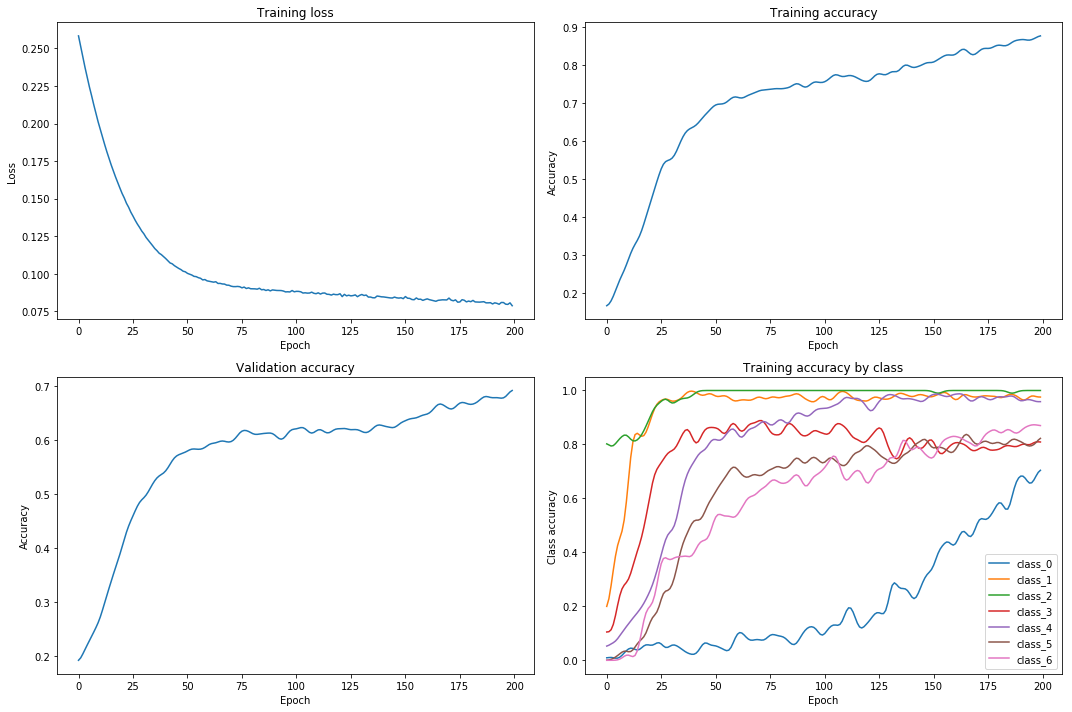

In [10]:
# Display graphs of how the model performed
from scipy.ndimage.filters import gaussian_filter1d

def smooth(key):
  return gaussian_filter1d(history.history[key], sigma=2)

print("Final loss: ", history.history['loss'][-1])
print("Final training accuracy: ", round(history.history['train_accuracy'][-1]*100), "%")

plt.rcParams['figure.figsize'] = [15, 10]

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.title("Training loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2, 2, 2)
plt.plot(smooth('train_accuracy'))
plt.title("Training accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 2, 3)
plt.plot(smooth('val_accuracy'))
plt.title("Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 2, 4)
for label in CLASS_LABELS:
  plt.plot(smooth("train_class_acc_"+str(label)))
plt.title("Training accuracy by class")
plt.ylabel('Class accuracy')
plt.xlabel('Epoch')
plt.legend(['class_'+str(label) for label in CLASS_LABELS], loc='lower right')

plt.tight_layout()
plt.show()


## Test the model

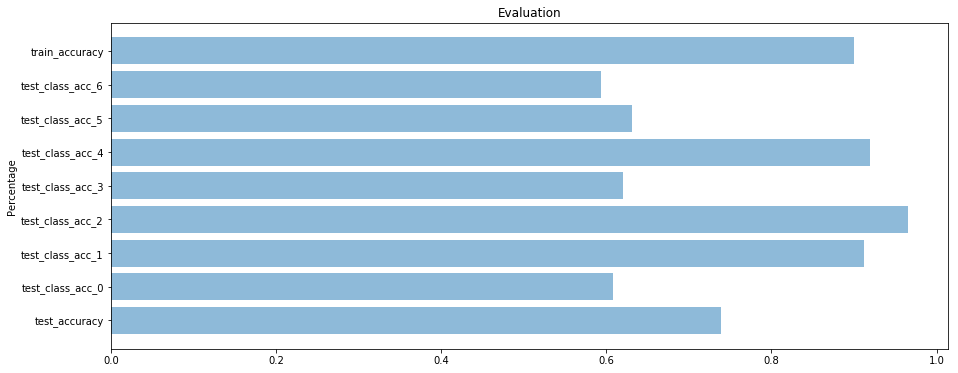

In [11]:
# Apply the trained model to our test data (that is, the held-out node labels)
# and measure how it performs
results = model.evaluate(
    initial_state, 
    y_test, 
    steps=1, 
    batch_size=NODE_COUNT, 
    verbose=0)

# Get test metrics
results_dict = dict(zip(model.metrics_names, results))
for name in model.metrics_names:
  if "test" not in name:
    del results_dict[name]

# Add train accuracy from the earlier training history
results_dict["train_accuracy"] = history.history['train_accuracy'][-1]

results_keys = list(results_dict.keys())
results_values = [results_dict[key] for key in results_keys]

plt.rcParams['figure.figsize'] = [15, 6]

# Display a bar chart
y_pos = np.arange(len(results_dict))
plt.barh(y_pos, results_values, align='center', alpha=0.5)
plt.yticks(y_pos, results_keys)
plt.ylabel('Percentage')
plt.title('Evaluation')
plt.show()

## Exercise questions and next steps


[Add your answers and discoveries to the answer document](https://docs.google.com/document/d/1QdAEOYnJ5AwFczNQZk5ZZo1Ng7_shn33GzQPdumnsvI/edit?usp=sharing)


- What train and test accuracy did you get?

- What modifications did you try to the network? How did they perform?

- Are there other graphs you find it useful to produce?

- What is the theoretical capabilities of this network? Do we need other methods of graph machine learning?

- Find an example of a Graph Convolutional Network being used in industry, link to it here and provide a summary

- How would you scale this network to a larger graph? What challenges might you encounter?

- Imagine you’re applying this method to Twitter’s tweet-reply graph. It’s constantly changing. How could you apply this method (which currently is written for a static graph)?

- How could you apply this to language (e.g. how could you treat language as a graph?)

